In [1]:
# KNN 
import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, roc_auc_score,recall_score, plot_roc_curve
import random
import os

In [2]:
train_directory = "../data_cnn/train"
test_directory = "../data_cnn/test"

cancer_train = glob.glob(f"{train_directory}/cancer/*")
non_cancer_train = glob.glob(f"{train_directory}/non_cancer/*")

cancer_test = glob.glob(f"{test_directory}/cancer/*")
non_cancer_test = glob.glob(f"{test_directory}/non_cancer/*")

print(f"Total training CANCER images: {len(cancer_train)}")
print(f"Total training NON CANCER images: {len(non_cancer_train)}")
print(f"Total test CANCER images: {len(cancer_test)}")
print(f"Total train NON CANCER images: {len(non_cancer_test)}")
print("--")
print("Total training images:", len(glob.glob(f'{train_directory}/*/*')))
print("Total test images:", len(glob.glob(f'{test_directory}/*/*')))

Total training CANCER images: 2800
Total training NON CANCER images: 5583
Total test CANCER images: 1200
Total train NON CANCER images: 2394
--
Total training images: 8383
Total test images: 3594


In [3]:
adimuc = glob.glob("../kaggle/input/tumor-detection/data/ADIMUC/*")
strmus = glob.glob("../kaggle/input/tumor-detection/data/STRMUS/*")
tumstu = glob.glob("../kaggle/input/tumor-detection/data/TUMSTU/*")




In [4]:
all_imgs = adimuc + strmus + tumstu

In [5]:
len(all_imgs)

11977

In [6]:
# convert 224 x 224 x 3 to 64 x 64 x 3 pixel images to reduce the size of our dataset.
# Also, normalize the image by dividing by 255
# Then flatten the image to a 1D array

def image_prepper(img, resize = (64,64)):
    open_img = np.array(Image.open(img))
    resized_img = cv2.resize(open_img, dsize = resize)/255.0
    return resized_img.flatten()

In [7]:
# # LOAD ALL DATA

X = []
y = []

for img in all_imgs:
    
    img_label = img.split('/')[-2]
    y.append(img_label)
    
    img_raw_pixels = image_prepper(img, resize = (64,64))
    X.append(img_raw_pixels)
    
    if len(y) % 2000 == 0:
        print(f"{len(y)} images have been processed")

# convert to numpy array
X = np.array(X)

# Convert labels to binary values.
# Cancer is 1:
# NONN CANCER is 0: the positive class
y_bin = np.where(np.array(y) == 'TUMSTU', 1, 0)

2000 images have been processed
4000 images have been processed
6000 images have been processed
8000 images have been processed
10000 images have been processed


In [8]:
np.array(y)

array(['ADIMUC', 'ADIMUC', 'ADIMUC', ..., 'TUMSTU', 'TUMSTU', 'TUMSTU'],
      dtype='<U6')

In [17]:
np.bincount(y_bin)

array([7977, 4000])

In [9]:
# Standard Scaler:
    
def standard_scaler(a):
    return (a-np.mean(a))/np.std(a)

X = np.apply_along_axis(standard_scaler, 0, X)

In [10]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_bin, 
                                                    train_size = 0.7, 
                                                    random_state = 42, 
                                                    stratify = y_bin)

In [11]:
# Incremental PCA due to memory issues:
# https://stackoverflow.com/questions/44334950/how-to-use-sklearns-incrementalpca-partial-fit

iPCA = IncrementalPCA(n_components = 10)

num_rows = X_train.shape[0]
chunk_size = 1000

# FIT on Training Data
for i in range(0, num_rows // chunk_size +1):
    iPCA.partial_fit(X_train[i*chunk_size : (i+1)*chunk_size])

# Transform Training Data
X_train_pca = iPCA.transform(X_train[0: chunk_size])

for i in range(1, num_rows // chunk_size +1):
    transformed_chunk = iPCA.transform(X_train[i*chunk_size : (i+1)*chunk_size])
    X_train_pca = np.concatenate((X_train_pca, transformed_chunk), axis = 0)
    
# Transform Test Data
X_test_pca = iPCA.transform(X_test[0: chunk_size])
num_rows = X_test.shape[0]

for i in range(1, num_rows // chunk_size +1):
    transformed_chunk = iPCA.transform(X_test[i*chunk_size : (i+1)*chunk_size])
    X_test_pca = np.concatenate((X_test_pca, transformed_chunk), axis = 0)

In [12]:
# Save space!
del X_train
del X_test

In [13]:
train_acc = []
test_acc = []
train_recall = []
test_recall = []
train_auc = []
test_auc = []
test_fn = []

num_neighbors = list(range(7,77,6))

for neighbors in num_neighbors:

    print(f"Fitting KNN with {neighbors} neighbors")
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    knn.fit(X_train_pca, y_train)
    
    y_train_preds = knn.predict(X_train_pca)
    y_test_preds = knn.predict(X_test_pca)
    
    train_acc.append(accuracy_score(y_train, y_train_preds))
    test_acc.append(accuracy_score(y_test, y_test_preds))
    
    train_recall.append(recall_score(y_train, y_train_preds))
    test_recall.append(recall_score(y_test, y_test_preds))
    
    train_auc.append(roc_auc_score(y_train, y_train_preds))
    test_auc.append(roc_auc_score(y_test, y_test_preds))
    
    fn = confusion_matrix(y_test, y_test_preds).ravel()[2] # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    test_fn.append(fn)

Fitting KNN with 7 neighbors
Fitting KNN with 13 neighbors
Fitting KNN with 19 neighbors
Fitting KNN with 25 neighbors
Fitting KNN with 31 neighbors
Fitting KNN with 37 neighbors
Fitting KNN with 43 neighbors
Fitting KNN with 49 neighbors
Fitting KNN with 55 neighbors
Fitting KNN with 61 neighbors
Fitting KNN with 67 neighbors
Fitting KNN with 73 neighbors


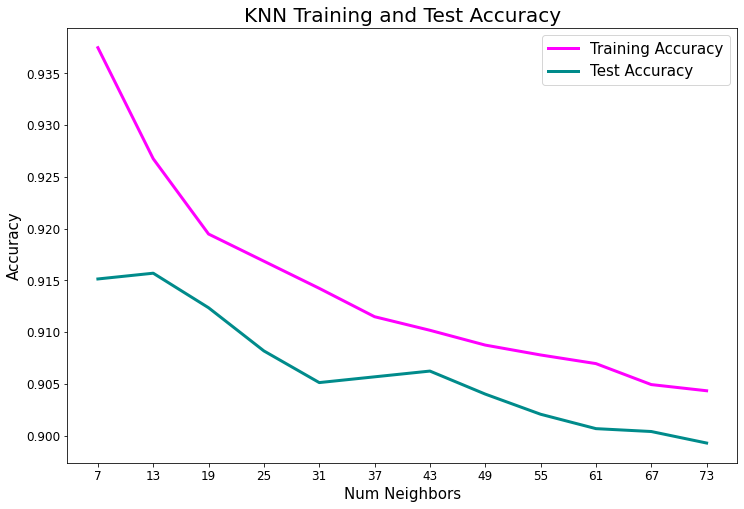

In [14]:
# TRAINING VS TESTING ACC
plt.figure(figsize = (12,8))
plt.plot(num_neighbors, train_acc, label='Training Accuracy', color = '#FF00FF', linewidth = 3)
plt.plot(num_neighbors, test_acc, label='Test Accuracy', color = '#008B8B', linewidth = 3)

plt.legend(loc='upper right', prop={'size': 15})
plt.title('KNN Training and Test Accuracy', fontsize = 20)
plt.xlabel('Num Neighbors', fontsize = 15);
plt.ylabel('Accuracy', fontsize = 15);
plt.xticks(num_neighbors, fontsize = 12)
plt.yticks(fontsize = 12);

plt.savefig('knn_acc.png',bbox_inches = 'tight')

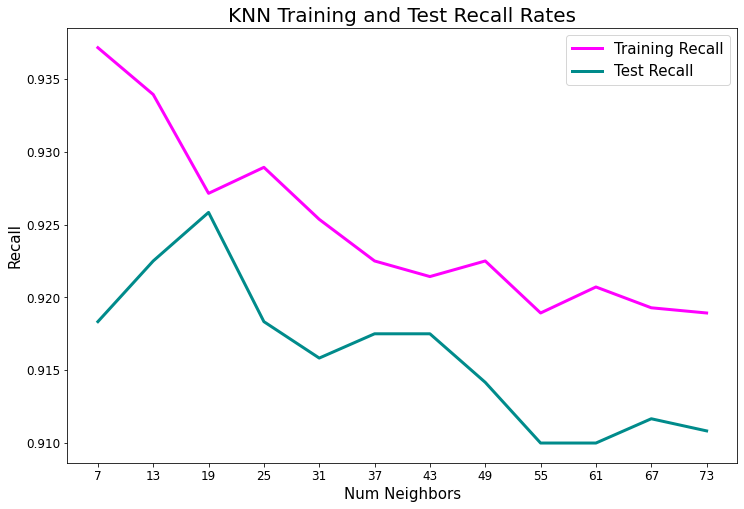

In [15]:
# TRAINING VS TESTING RECALL
plt.figure(figsize = (12,8))
plt.plot(num_neighbors, train_recall, label='Training Recall', color = '#FF00FF', linewidth = 3)
plt.plot(num_neighbors, test_recall, label='Test Recall', color = '#008B8B', linewidth = 3)
plt.legend(loc='upper right', prop={'size': 15})
plt.title('KNN Training and Test Recall Rates', fontsize = 20)
plt.xlabel('Num Neighbors', fontsize = 15);
plt.ylabel('Recall', fontsize = 15);
plt.xticks(num_neighbors, fontsize = 12)
plt.yticks(fontsize = 12);

plt.savefig('knn_recall.png',bbox_inches = 'tight')

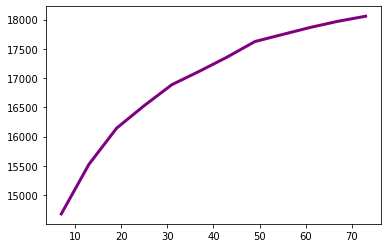

In [27]:
plt.plot(num_neighbors, test_fn, color = 'purple', linewidth = 3)

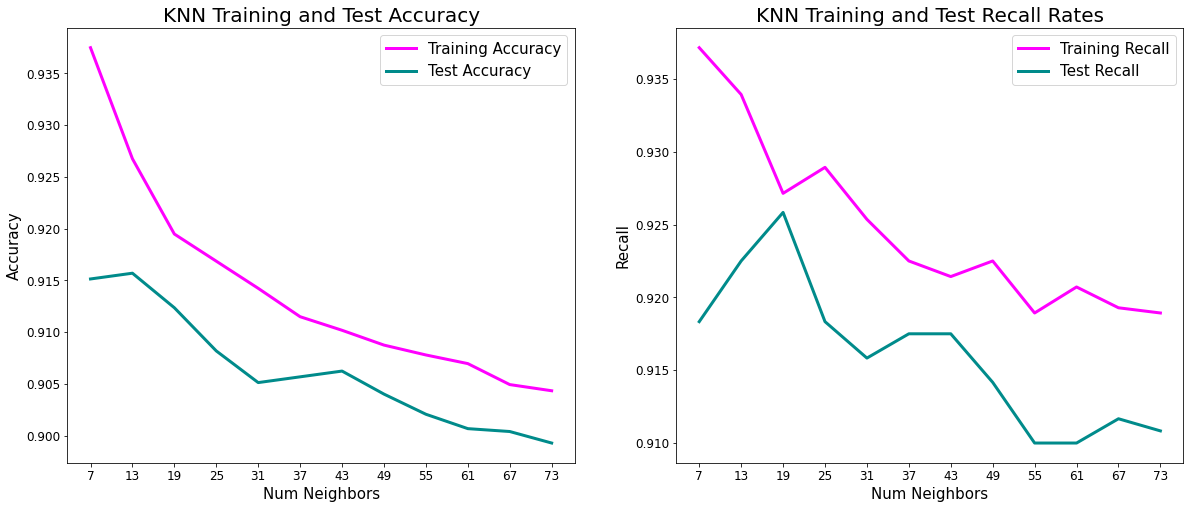

In [16]:
# Look for best train and test metrics!

# TRAINING VS TESTING ACC
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(num_neighbors, train_acc, label='Training Accuracy', color = '#FF00FF', linewidth = 3)
plt.plot(num_neighbors, test_acc, label='Test Accuracy', color = '#008B8B', linewidth = 3)
plt.legend(loc='upper right', prop={'size': 15})
plt.title('KNN Training and Test Accuracy', fontsize = 20)
plt.xlabel('Num Neighbors', fontsize = 15);
plt.ylabel('Accuracy', fontsize = 15);
plt.xticks(num_neighbors, fontsize = 12)
plt.yticks(fontsize = 12);

plt.subplot(1, 2, 2)
plt.plot(num_neighbors, train_recall, label='Training Recall', color = '#FF00FF', linewidth = 3)
plt.plot(num_neighbors, test_recall, label='Test Recall', color = '#008B8B', linewidth = 3)
plt.legend(loc='upper right', prop={'size': 15})
plt.title('KNN Training and Test Recall Rates', fontsize = 20)
plt.xlabel('Num Neighbors', fontsize = 15);
plt.ylabel('Recall', fontsize = 15);
plt.xticks(num_neighbors, fontsize = 12)
plt.yticks(fontsize = 12);

plt.savefig("knn_metrics.png", bbox_inches ='tight')

In [19]:
X_train_pca.shape

(8383, 10)

In [20]:
X_test_pca.shape

(3594, 10)

In [21]:
best_idx = np.argwhere(np.array(num_neighbors) == 19)[0][0]

In [22]:
np.round(train_acc[best_idx])
np.round(test_acc[best_idx])
np.round(train_recall[best_idx])
np.round(test_recall[best_idx])
np.round(test_auc[best_idx])
np.round(test_fn[best_idx])

89

In [50]:
knn = KNeighborsClassifier(n_neighbors = 43)
knn.fit(X_train_pca, y_train)
print(roc_auc_score(y_train, y_train_preds))
print(roc_auc_score(y_test, y_test_preds))

0.5529483817177808
0.5396777552745623


In [51]:
test_auc[best_idx]

0.5407822464619657

In [23]:
metrics = [np.round(train_acc[best_idx], 3),
np.round(test_acc[best_idx], 3),
np.round(train_recall[best_idx], 3),
np.round(test_recall[best_idx], 3),
np.round(roc_auc_score(y_train, y_train_preds), 3),
np.round(test_auc[best_idx], 3)]

In [26]:
test_results = pd.DataFrame(metrics,
                             index = ['Train Accuracy','Test Accuracy', 'Train Recall', 'Test Recall', 'Train AUC', 'Test AUC'],
                             columns = ['KNN - 19 Neighbors']).T
print(test_results.round(3).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Train Accuracy</th>
      <th>Test Accuracy</th>
      <th>Train Recall</th>
      <th>Test Recall</th>
      <th>Train AUC</th>
      <th>Test AUC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>KNN - 19 Neighbors</th>
      <td>0.919</td>
      <td>0.912</td>
      <td>0.927</td>
      <td>0.926</td>
      <td>0.908</td>
      <td>0.916</td>
    </tr>
  </tbody>
</table>


In [25]:
test_results

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train AUC,Test AUC
KNN - 47 Neighbors,0.919,0.912,0.927,0.926,0.908,0.916


In [27]:
print(iPCA.explained_variance_ratio_)

[0.55486007 0.02349768 0.00812628 0.0053433  0.00436631 0.00335188
 0.00287211 0.00258945 0.00235716 0.002197  ]


In [28]:
print(np.sum(iPCA.explained_variance_ratio_))

0.6095612220917649
